# Interactive TinyMPC Example in Python
We demonstrate an interactive workflow in Python with TinyMPC where you can generate C code and interact with it via Python. This example uses cartpole model.

Load necessary packages, make sure to install `tinympc` ([README.md](../README.md))

In [38]:
import ctypes
import tinympc
import numpy as np
import subprocess
import os
import math

Define the class and compile original TinyMPC code to get a generic shared/dynamic library

**PLEASE CHANGE `tinympc_python_dir` TO YOUR ABSOLUTE PATH**

In [39]:
prob = tinympc.TinyMPC()

tinympc_python_dir = "/home/khai/SSD/Code/tinympc-python"  # Your absolute path to the tinympc-python directory, you may only need to change this

tinympc_dir = tinympc_python_dir + "/tinympc/TinyMPC"  # Path to the TinyMPC directory (C code)
prob.compile_lib(tinympc_dir)  # Compile the library

True

Load the generic shared/dynamic library 

In [40]:
lib_dir = tinympc_dir + "/build/src/tinympc/libtinympcShared.so"
prob.load_lib(lib_dir)  # Load the library

Problem data includes cartpole LTI model, cost weights, constraints and settings. All matrices are in row-major order and types are double and integer

In [41]:
n = 4
m = 1
N = 10

A = [
    1,
    0,
    0,
    0,
    0.01,
    1,
    0,
    0,
    2.2330083403300767e-5,
    0.004466210576510177,
    1.0002605176397052,
    0.05210579005928538,
    7.443037974683548e-8,
    2.2330083403300767e-5,
    0.01000086835443038,
    1.0002605176397052,
]  # A matrix in row-major order
B = [
    7.468368562730335e-5,
    0.014936765390161838,
    3.79763323185387e-5,
    0.007595596218554721,
]  # B matrix in row-major order
Q = [10, 1, 10, 1]
R = [1]
rho = 0.1

x_min = [-5] * n * N
x_max = [5] * n * N
u_min = [-5] * m * (N - 1)
u_max = [5] * m * (N - 1)

abs_pri_tol = 1e-3
abs_dual_tol = 1e-3
max_iter = 100
check_termination = 1

# Setup problem data
prob.setup(n, m, N, A, B, Q, R, x_min, x_max, u_min, u_max, rho, abs_pri_tol, abs_dual_tol, max_iter, check_termination)

True

After define the problem, we generate the tailored code with above data. 

Here we compile it for interactive Python script but you can use it directly for your applications/systems

In [42]:
output_dir = tinympc_python_dir + "/generated_code"  # Path to the generated code
prob.tiny_codegen(tinympc_dir, output_dir)
prob.compile_lib(output_dir)

True

Load the compiled shared/dynamic library

In [43]:
prob.load_lib(output_dir + "/build/tinympc/libtinympcShared.so")  

Run the interactive MPC example which calls the generated code

In [44]:
x = [0.5, -0.2, 0.1, 0]  # Initial state
u = [0.0] * m * (N - 1)  # List of control inputs in horizon
x_all = []  # List of all stored states

# Matrices for simulation
Anp = np.array(A).reshape((n, n)).transpose()
Bnp = np.array(B).reshape((n, m))

print("=== START INTERACTIVE MPC ===")

NSIM = 300
for i in range(NSIM):
    # Set initial state to C code
    prob.set_x0(x, 0)  
    # Call the solve in C code
    prob.solve(0)  
    # Get the control input from C code
    prob.get_u(u, 0) 
    # print(np.array(u[0]))
    x = Anp@np.array(x).reshape((n, 1))+ Bnp*np.array(u[0])
    # print(f"X = {x}")
    x = x.reshape(n).tolist()
    # print(f"X = {x}")
    x_all.append(x)

print(len(x_all))

=== START INTERACTIVE MPC ===
300


Visualize the robot and trajectory

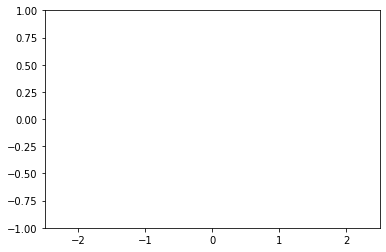

In [45]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set up the figure and axis for plotting
fig, ax = plt.subplots()
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-1, 1)

# Initialize the cartpole visualization
cart, = ax.plot([], [], 'bo', markersize=20)
pole, = ax.plot([], [], 'r-', linewidth=4)

def init():
    cart.set_data([], [])
    pole.set_data([], [])
    return cart, pole

def update(frame):
    x = x_all[frame]
    # Update the cart position
    cart.set_data([x[0]], [0])

    # Update the pole position
    pole.set_data([x[0], x[0] + 0.5*math.sin(x[1])], [0, 0.5 * math.cos(x[1])])
    # print(frame)
    # if frame==NSIM-1:
    #     ani.event_source.stop()  # Stop the animation if the episode is 
    return cart, pole

# Create the animation
ani = FuncAnimation(fig, update, frames=NSIM, init_func=init, blit=False, interval=10)

# Display the animation (may not display anything in notebook :D, that's why I save it to a file)
plt.show(ani)

Save the animation

In [46]:
ani.save('cartpole.mp4', writer='ffmpeg', fps=30, dpi=200)

After testing MPC procedure with the generated code, you need to deploy it for your applications/systems. Stay tuned for Teensy and STM32 deployment tutorials. 

Your `tiny_main` may look like this

```C
int main()
{
    int exitflag = 1;
    TinyWorkspace* work = tiny_data_solver.work;
    tiny_data_solver.work->Xref = tiny_MatrixNxNh::Zero();
    tiny_data_solver.work->Uref = tiny_MatrixNuNhm1::Zero();
    tiny_data_solver.settings->max_iter = 150;
    tiny_data_solver.settings->en_input_bound = 1;
    tiny_data_solver.settings->en_state_bound = 1;

    tiny_VectorNx x0, x1; // current and next simulation states
    x0 << 0.0, 0, 0.1, 0; // initial state

    int i = 0;
    for (int k = 0; k < 300; ++k)
    {
        printf("tracking error at step %2d: %.4f\n", k, (x0 - work->Xref.col(1)).norm());

        // 1. Update measurement
        work->x.col(0) = x0;

        // 2. Update reference (if needed)
        // you can also use C wrapper (intended for high-level languages) 
        // by including tiny_wrapper.hpp and call `set_xref(...)` function

        // 3. Reset dual variables (if needed)
        work->y = tiny_MatrixNuNhm1::Zero();
        work->g = tiny_MatrixNxNh::Zero();

        // 4. Solve MPC problem
        exitflag = tiny_solve(&tiny_data_solver);

        // if (exitflag == 0)
        // 	printf("HOORAY! Solved with no error!\n");
        // else
        // 	printf("OOPS! Something went wrong!\n");
        // 	// break;

        std::cout << work->iter << std::endl;
        std::cout << work->u.col(0).transpose().format(CleanFmt) << std::endl;

        // 5. Simulate forward
        // work->u.col(0) = -tiny_data_solver.cache->Kinf * (x0 - work->Xref.col(0));
        x1 = work->Adyn * x0 + work->Bdyn * work->u.col(0);
        x0 = x1;
        // std::cout << x0.transpose().format(CleanFmt) << std::endl;
    }
}
```